# TileDB-Video-Py Demo

#### First install some extra libraries and import the required modules:

In [1]:
!pip install pandas pyarrow mediapy --quiet

import mediapy
import tiledb.video
from IPython.display import Video

## Converting to TileDB

#### Display an example video file:

In [2]:
input_file = "file_example_MP4_640_3MG.mp4"

!du -h $input_file
Video(input_file)

3,0M	file_example_MP4_640_3MG.mp4


#### Convert it to a TileDB array with `tiledb.video.from_file`:

In [3]:
import os

tiledb_uri = "file_example_MP4_640_3MG.tdb"
if not os.path.exists(tiledb_uri):    
    tiledb.video.from_file(tiledb_uri, input_file)

!du -sh $tiledb_uri

2,9M	file_example_MP4_640_3MG.tdb


## Getting codec context metadata

#### Get some properties of the video stream codec context with `tiledb.video.get_codec_context`:

In [4]:
tiledb.video.get_codec_context(tiledb_uri)

{'codec': 'h264',
 'fps': Fraction(30, 1),
 'bitrate': 710666,
 'pixel_format': 'yuv420p',
 'height': 360,
 'width': 640}

## Extracting a video sample

#### Extract a video sample between the 11th and 16th second to a new file with `tiledb.video.to_file`:

In [5]:
start_time = 11
end_time = 16
sample_file = f"file_example_MP4_640_3MG-{start_time}_{end_time}.mp4"
tiledb.video.to_file(tiledb_uri, sample_file, start_time=start_time, end_time=end_time)
Video(sample_file)

#### The same function can create a file in memory:

In [6]:
import io

buf = io.BytesIO()
tiledb.video.to_file(tiledb_uri, buf, start_time=start_time, end_time=end_time)
print(len(buf.getvalue()), "\t", buf)
!du -sb $sample_file

666940 	 <_io.BytesIO object at 0x7fe433a13d10>
666940	file_example_MP4_640_3MG-11_16.mp4


#### A video sample can also be extracted as an iterator of Numpy arrays in RGB format with `tiledb.video.iter_ndarrays`: 

In [7]:
images = tiledb.video.iter_ndarrays(tiledb_uri, start_time=start_time, end_time=end_time)
image = next(images)
print("Image:", image.__class__, image.dtype, image.shape)
mediapy.show_video(images)

Image: <class 'numpy.ndarray'> uint8 (360, 640, 3)


#### Or as an iterator of `PIL.Image`s with `tiledb.video.iter_images`: 

Image: <PIL.Image.Image image mode=RGB size=640x360 at 0x7FE433A2A750>


,,,

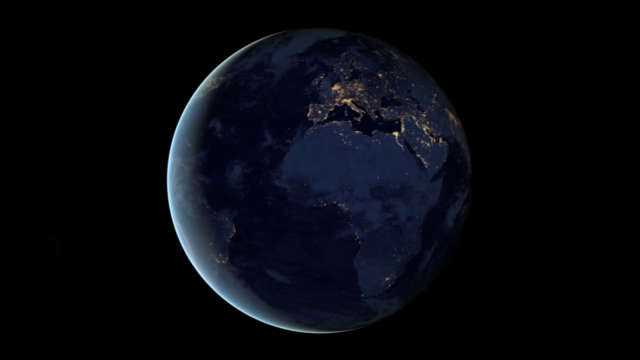
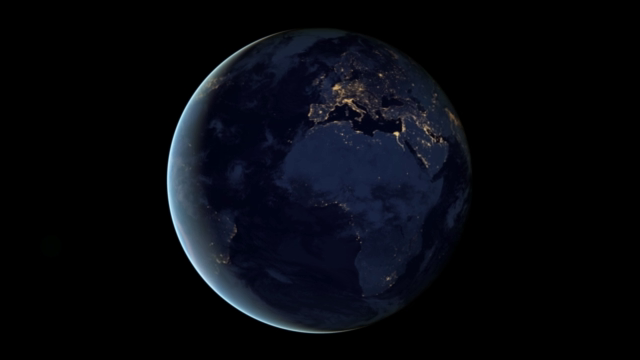
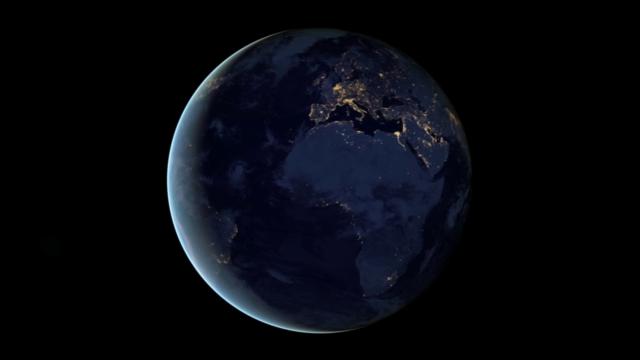
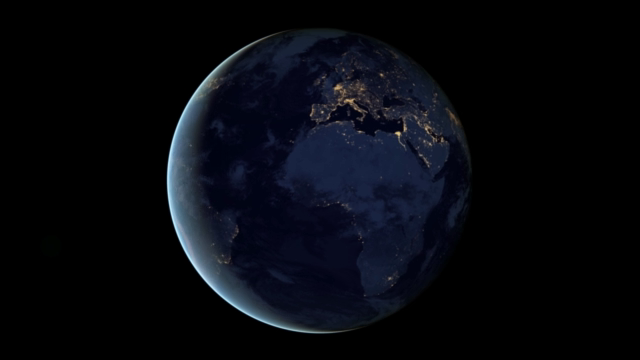

In [8]:
import itertools as it

images = tiledb.video.iter_images(tiledb_uri, start_time=start_time, end_time=end_time)
image = next(images)
print("Image:", image)
mediapy.show_images(it.islice(images, 4))

## Inspecting the TileDB array

#### As with every TileDB array, its schema is available:

In [9]:
import tiledb

with tiledb.open(tiledb_uri) as tiledb_array:
    print(tiledb_array.schema)

ArraySchema(
  domain=Domain(*[
    Dim(name='start_time', domain=(0.0, 1000000.0), tile='1.0', dtype='float64'),
    Dim(name='end_time', domain=(0.0, 1000000.0), tile='1.0', dtype='float64'),
  ]),
  attrs=[
    Attr(name='data', dtype='|S0', var=True, nullable=False, filters=FilterList([NoOpFilter(), ])),
    Attr(name='size', dtype='uint32', var=False, nullable=False),
  ],
  cell_order='row-major',
  tile_order='row-major',
  capacity=10000,
  sparse=True,
  allows_duplicates=False,
  coords_filters=FilterList([ZstdFilter(level=-1)]),
)



#### The original video is split into smaller video segments. For every segment, its start and end time are stored as dimensions and its raw binary data and size as attributes:

In [10]:
with tiledb.open(tiledb_uri) as tiledb_array:
    df = tiledb_array.query(use_arrow=False, attrs=["size"]).df[:]
    df["duration"] = df["end_time"] - df["start_time"]
df

,start_time,end_time,size,duration
0,0.0,2.966667,246246,2.966667
1,3.0,5.966667,298164,2.966667
2,6.0,8.966667,294684,2.966667
3,9.0,11.966667,292007,2.966667
4,12.0,14.966667,273653,2.966667
5,15.0,17.966667,251831,2.966667
6,18.0,20.966667,229448,2.966667
7,21.0,23.966667,230709,2.966667
8,24.0,26.966667,267240,2.966667
9,27.0,29.966667,283061,2.966667


#### So the original 30 second video is segmented into 10 segments of 3 seconds each, plus one last segment of some traling frames.